In [133]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

## Load and manage data ##

In [134]:
# Load the dataset
df = pd.read_csv("data/player_10yr_stats.csv")
print('Dataset loaded. Shape:', df.shape)

Dataset loaded. Shape: (265, 123)


In [135]:
df.head(3)

,name,rookie_year,rookie_age,Y1_pts_per_g,Y1_ast_per_g,Y1_trb_per_g,Y1_stl_per_g,Y1_blk_per_g,Y1_mp_per_g,Y1_games_started,...,Y10_trb_per_g,Y10_stl_per_g,Y10_blk_per_g,Y10_mp_per_g,Y10_games_started,Y10_per,Y10_ts_pct,Y10_usg_pct,Y10_ws,Y10_bpm
0,Carmelo Anthony*,2004,19,21.0,2.8,6.1,1.2,0.5,36.5,82.0,...,6.9,0.8,0.5,37.0,67.0,24.8,0.560,35.6,9.5,4.3
1,Leandro Barbosa,2004,21,7.9,2.4,1.8,1.3,0.1,21.4,46.0,...,1.1,0.4,0.1,12.5,2.0,13.5,0.509,21.4,0.9,-0.7
2,Matt Barnes,2004,23,4.5,1.3,4.0,0.7,0.1,19.1,9.0,...,4.6,1.0,0.8,25.7,4.0,15.5,0.566,18.1,6.3,1.8


In [136]:
# add more useful columns
for year in range(1, 11):
    df[f"Y{year}_pts_per_36"] = (df[f"Y{year}_pts_per_g"] / df[f"Y{year}_mp_per_g"]) * 36
df["pts_growth"] = df["Y3_pts_per_g"] - df["Y1_pts_per_g"]
df["ast_growth"] = df["Y3_ast_per_g"] - df["Y1_ast_per_g"]
df["pp36_growth"] = df["Y3_pts_per_36"] - df["Y1_pts_per_36"]
df["per_growth"] = df["Y3_per"] - df["Y1_per"]
df["ts_growth"] = df["Y3_ts_pct"] - df["Y1_ts_pct"]
df["usg_growth"] = df["Y3_usg_pct"] - df["Y1_usg_pct"]
df["ws_growth"] = df["Y3_ws"] - df["Y1_ws"]
df["bpm_growth"] = df["Y3_bpm"] - df["Y1_bpm"]


## select features and train/test split ##

In [137]:
input_cols = ["rookie_age", "pts_growth", "ast_growth", "per_growth", "ts_growth", "usg_growth", "ws_growth", "bpm_growth"] + [
                    f"Y{year}_{stat}" 
                    for year in range(1, 4)
                    for stat in ["pts_per_g", "ast_per_g", "trb_per_g", "stl_per_g", "blk_per_g", "mp_per_g", "per", "usg_pct", "bpm"]
            ]

In [138]:
# Target: average points per game in years 4–10
df["avg_pts_future"] = df[[f"Y{y}_pts_per_g" for y in range(4, 11)]].mean(axis=1)
df["avg_ast_future"] = df[[f"Y{y}_ast_per_g" for y in range(4, 11)]].mean(axis=1)
df["avg_trb_future"] = df[[f"Y{y}_trb_per_g" for y in range(4, 11)]].mean(axis=1)
df["avg_stl_future"] = df[[f"Y{y}_stl_per_g" for y in range(4, 11)]].mean(axis=1)
df["avg_blk_future"] = df[[f"Y{y}_blk_per_g" for y in range(4, 11)]].mean(axis=1)
df["avg_per_future"] = df[[f"Y{y}_per" for y in range(4, 11)]].mean(axis=1)
df["avg_ts_future"] = df[[f"Y{y}_ts_pct" for y in range(4, 11)]].mean(axis=1)
df["avg_usg_future"] = df[[f"Y{y}_usg_pct" for y in range(4, 11)]].mean(axis=1)
df["avg_ws_future"] = df[[f"Y{y}_ws" for y in range(4, 11)]].mean(axis=1)
df["avg_bpm_future"] = df[[f"Y{y}_bpm" for y in range(4, 11)]].mean(axis=1)

target_cols = ["avg_pts_future", "avg_ast_future", "avg_trb_future", "avg_stl_future", "avg_blk_future", "avg_bpm_future"]

In [139]:
df_model = df[input_cols + target_cols + ["name"]].dropna()

X = df_model[input_cols]
y = df_model[target_cols]
names = df_model["name"].values

X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(
    X, y, names, test_size=0.2, random_state=42, shuffle=True
)


## Random Forest ##

In [140]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

base_model = RandomForestRegressor(
    n_estimators=150,
    max_depth=10,
    random_state=42,
    n_jobs=-1       
)

In [141]:
model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=10,
                                                     n_estimators=150,
                                                     n_jobs=-1,
                                                     random_state=42))

In [142]:
y_pred = model.predict(X_test)

# Round predictions first
ppg_pred = np.round(y_pred[:, 0].astype(float), 2)
apg_pred = np.round(y_pred[:, 1], 2)
rpg_pred = np.round(y_pred[:, 2], 2)


# Create DataFrame
results_df = pd.DataFrame({
    "Player": names_test,
    "Actual PPG": y_test["avg_pts_future"].values.round(2),
    "Predicted PPG": ppg_pred,
    "Actual APG": y_test["avg_ast_future"].values.round(2),
    "Predicted APG": apg_pred,
    "Actual RPG": y_test["avg_trb_future"].values.round(2),
    "Predicted RPG": rpg_pred,
    "Actual SPG": y_test["avg_stl_future"].values.round(2),
    "Predicted SPG": np.round(y_pred[:, 3], 2),
    "Actual BPG": y_test["avg_blk_future"].values.round(2),
    "Predicted BPG": np.round(y_pred[:, 4], 2),
    #"Actual WS": y_test["avg_ws_future"].values.round(2),
    #"Predicted WS": np.round(y_pred[:, 5], 2),
    "Actual BPM": y_test["avg_bpm_future"].values.round(2),
    "Predicted BPM": np.round(y_pred[:, 5], 2)
})

In [143]:
print("\nSample Results:")
print(results_df.sort_values("Actual BPM", ascending=False).head(10).to_string(index=False))



Sample Results:
            Player  Actual PPG  Predicted PPG  Actual APG  Predicted APG  Actual RPG  Predicted RPG  Actual SPG  Predicted SPG  Actual BPG  Predicted BPG  Actual BPM  Predicted BPM
      Kevin Durant       27.79          24.87        4.31           3.15        7.60           7.97        1.16           1.50        1.13           0.86        8.60           5.48
        Chris Paul       18.90          23.31       10.17           8.04        4.29           4.71        2.37           1.68        0.13           0.16        8.41           6.36
      Dwyane Wade*       25.37          24.85        6.10           6.70        4.99           5.60        1.84           1.59        1.07           1.01        7.11           6.71
Karl-Anthony Towns       23.90          22.79        3.83           2.88       10.40          11.85        0.86           0.97        1.00           1.51        4.63           5.09
       Rudy Gobert       14.54           8.85        1.39           2.83      

In [144]:
# List of your target column names, in the same order as model output
target_names = ["avg_pts_future", "avg_ast_future", "avg_trb_future", "avg_bpm_future"]  # adjust if needed

print("\nModel Evaluation by Target:\n")
for i, target in enumerate(target_names):
    y_true = y_test.iloc[:, i] if hasattr(y_test, "iloc") else y_test[:, i]
    y_pred_col = y_pred[:, i]

    mae = mean_absolute_error(y_true, y_pred_col)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_col))
    r2 = r2_score(y_true, y_pred_col)

    print(f"{target}:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.3f}\n")



Model Evaluation by Target:

avg_pts_future:
  MAE:  3.09
  RMSE: 3.69
  R²:   0.582

avg_ast_future:
  MAE:  0.74
  RMSE: 0.97
  R²:   0.755

avg_trb_future:
  MAE:  1.19
  RMSE: 1.57
  R²:   0.719

avg_bpm_future:
  MAE:  0.23
  RMSE: 0.27
  R²:   0.575



## Gradient Boosting ##

In [145]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

# Train XGBoost model
base_model = XGBRegressor(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=6,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

In [146]:
model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=150, n_jobs=-1,
                                            num_parallel_tree=None, ...))

In [147]:
y_pred = model.predict(X_test)

# Round predictions first
ppg_pred = np.round(y_pred[:, 0].astype(float), 2)
apg_pred = np.round(y_pred[:, 1], 2)
rpg_pred = np.round(y_pred[:, 2], 2)


# Create DataFrame
results_df = pd.DataFrame({
    "Player": names_test,
    "Actual PPG": y_test["avg_pts_future"].values.round(2),
    "Predicted PPG": ppg_pred,
    "Actual APG": y_test["avg_ast_future"].values.round(2),
    "Predicted APG": apg_pred,
    "Actual RPG": y_test["avg_trb_future"].values.round(2),
    "Predicted RPG": rpg_pred,
    "Actual SPG": y_test["avg_stl_future"].values.round(2),
    "Predicted SPG": np.round(y_pred[:, 3], 2),
    "Actual BPG": y_test["avg_blk_future"].values.round(2),
    "Predicted BPG": np.round(y_pred[:, 4], 2),
    #"Actual WS": y_test["avg_ws_future"].values.round(2),
    #"Predicted WS": np.round(y_pred[:, 5], 2),
    "Actual BPM": y_test["avg_bpm_future"].values.round(2),
    "Predicted BPM": np.round(y_pred[:, 5], 2)
})

In [148]:
print("\nSample Results:")
print(results_df.sort_values("Actual BPM", ascending=False).head(10).to_string(index=False))

#print("\nModel Evaluation:")
#print("Mean Absolute Error (MAE):", round(mean_absolute_error(y_test, y_pred), 2))
#print("Mean Squared Error (MSE):", round(mean_squared_error(y_test, y_pred), 2))
#print("Root Mean Squared Error (RMSE):", round(np.sqrt(mean_squared_error(y_test, y_pred)), 2))
#print("R-squared (R2):", round(r2_score(y_test, y_pred), 2))


Sample Results:
            Player  Actual PPG  Predicted PPG  Actual APG  Predicted APG  Actual RPG  Predicted RPG  Actual SPG  Predicted SPG  Actual BPG  Predicted BPG  Actual BPM  Predicted BPM
      Kevin Durant       27.79          25.44        4.31           3.00        7.60           8.12        1.16           1.63        1.13           0.95        8.60           3.75
        Chris Paul       18.90          22.38       10.17           8.90        4.29           4.65        2.37           1.56        0.13           0.15        8.41           7.63
      Dwyane Wade*       25.37          26.25        6.10           5.01        4.99           5.84        1.84           1.24        1.07           0.99        7.11           6.28
Karl-Anthony Towns       23.90          23.33        3.83           3.04       10.40          11.11        0.86           1.02        1.00           1.23        4.63           4.25
       Rudy Gobert       14.54          11.35        1.39           2.94      

In [149]:
# List of your target column names, in the same order as model output
target_names = ["avg_pts_future", "avg_ast_future", "avg_trb_future", "avg_bpm_future"]  # adjust if needed

print("\nModel Evaluation by Target:\n")
for i, target in enumerate(target_names):
    y_true = y_test.iloc[:, i] if hasattr(y_test, "iloc") else y_test[:, i]
    y_pred_col = y_pred[:, i]

    mae = mean_absolute_error(y_true, y_pred_col)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_col))
    r2 = r2_score(y_true, y_pred_col)

    print(f"{target}:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.3f}\n")



Model Evaluation by Target:

avg_pts_future:
  MAE:  2.85
  RMSE: 3.38
  R²:   0.649

avg_ast_future:
  MAE:  0.79
  RMSE: 1.01
  R²:   0.734

avg_trb_future:
  MAE:  1.28
  RMSE: 1.78
  R²:   0.640

avg_bpm_future:
  MAE:  0.22
  RMSE: 0.29
  R²:   0.493



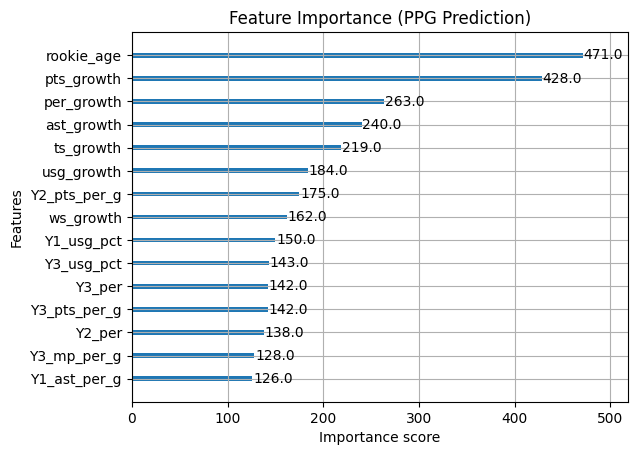

In [150]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model.estimators_[0], max_num_features=15)
plt.title("Feature Importance (PPG Prediction)")
plt.show()


## Neural Network ##

In [151]:
from sklearn.neural_network import MLPRegressor

# Define input and output columns
input_cols = [
    "rookie_age", "pts_growth", "ast_growth", "per_growth", "ts_growth", "usg_growth", "ws_growth", 
] + [
    f"Y{year}_{stat}"
    for year in range(1, 4)
    for stat in ["pts_per_g", "ast_per_g", "trb_per_g", "mp_per_g"]
]

target_cols = [
    "avg_pts_future", "avg_ast_future", "avg_trb_future", "avg_bpm_future"
]

In [152]:
# Prepare data
df_model = df[input_cols + target_cols + ["name"]].dropna()
X = df_model[input_cols]
y = df_model[target_cols]
names = df_model["name"]

# Split
X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(
    X, y, names, test_size=0.2, random_state=42
)

In [153]:
# Initialize and fit MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(150, 75), activation='relu', solver='adam', max_iter=2048, random_state=42)
model = MultiOutputRegressor(mlp)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


# Sample predictions
results_df = pd.DataFrame({
    "Player": names_test.values,
    "Actual PPG": y_test["avg_pts_future"].values.round(2),
    "Predicted PPG": y_pred[:, 0].round(2),
    "Actual APG": y_test["avg_ast_future"].values.round(2),
    "Predicted APG": y_pred[:, 1].round(2),
    "Actual RPG": y_test["avg_trb_future"].values.round(2),
    "Predicted RPG": y_pred[:, 2].round(2),
    "Actual BPM": y_test["avg_bpm_future"].values.round(2),
    "Predicted BPM": y_pred[:, 3].round(2),
})

print("Sample Results:")
print(results_df.sort_values("Actual BPM", ascending=False).head(10).to_string(index=False))

Sample Results:
            Player  Actual PPG  Predicted PPG  Actual APG  Predicted APG  Actual RPG  Predicted RPG  Actual BPM  Predicted BPM
      Kevin Durant       27.79          21.64        4.31           3.53        7.60           7.03        8.60           9.60
        Chris Paul       18.90          19.31       10.17          10.14        4.29           5.07        8.41           6.84
      Dwyane Wade*       25.37          20.43        6.10           7.29        4.99           6.40        7.11           6.07
Karl-Anthony Towns       23.90          17.81        3.83           2.56       10.40          10.70        4.63           2.22
       Rudy Gobert       14.54          12.43        1.39           3.23       12.81          10.87        3.86           4.41
      Eric Bledsoe       17.81           9.24        5.70           2.41        4.53           2.59        2.79          -1.91
 LaMarcus Aldridge       21.01          16.34        2.14           2.93        9.10           

In [154]:
# Evaluate
print("\nModel Evaluation by Target:\n")
for i, target in enumerate(target_cols):
    y_true = y_test.iloc[:, i]
    y_pred_col = y_pred[:, i]

    mae = mean_absolute_error(y_true, y_pred_col)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_col))
    r2 = r2_score(y_true, y_pred_col)

    print(f"{target}:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.3f}\n")


Model Evaluation by Target:

avg_pts_future:
  MAE:  3.34
  RMSE: 3.95
  R²:   0.520

avg_ast_future:
  MAE:  1.02
  RMSE: 1.26
  R²:   0.589

avg_trb_future:
  MAE:  1.61
  RMSE: 2.16
  R²:   0.468

avg_bpm_future:
  MAE:  1.88
  RMSE: 2.30
  R²:   0.307

